In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from models import Model

/Users/I551393/Library/Caches/pypoetry/virtualenvs/tsf-ss25-timegpt-9SjHUXw4-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.10.18 (main, Jun  3 2025, 18:23:41) [Clang 17.0.0 (clang-1700.0.13.3)].


In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Undestanding

In [3]:
df = pd.read_csv('../../transformed_data/cleaned_australian_electricity_demand.csv')
df['ts'] = pd.to_datetime(df['ts'])
df = df.sort_values('ts').reset_index(drop=True)
df.rename(columns={"series_value": "y"}, inplace=True)
print("Length of the df: ", len(df))

Length of the df:  230736


231


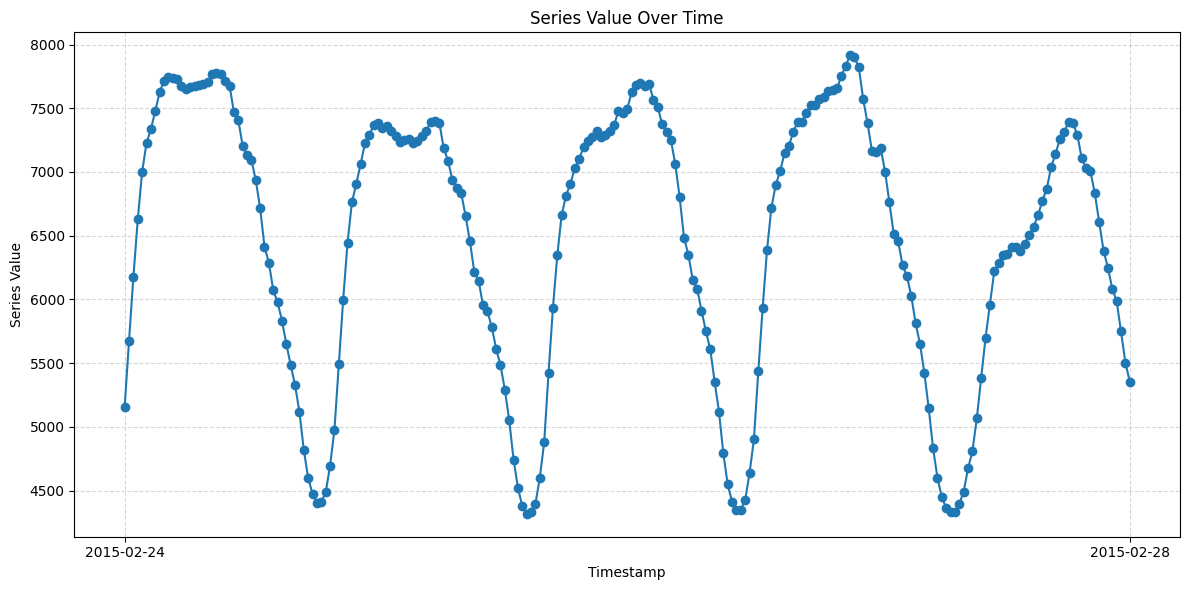

In [4]:
df_short = df[int(len(df) * 0.999):]
print(len(df_short))

start = df_short['ts'].min()
end = df_short['ts'].max()


plt.figure(figsize=(12, 6))
plt.plot(df_short['ts'], df_short['y'], marker='o')

# Start and End-Ticks
plt.xticks([start, end], [start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')])

plt.xlabel('Timestamp')
plt.ylabel('Series Value')
plt.title('Series Value Over Time')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [5]:
# shortening the dataset
df_recent = df.tail(10000).copy()
train_ratio = 0.8
split_idx   = int(len(df_recent) * train_ratio)

df_train = df_recent.iloc[:split_idx].copy().reset_index(drop=True)
df_test  = df_recent.iloc[split_idx:].copy().reset_index(drop=True)

print("Duplicates:", df_recent.duplicated().sum())
print("NaNs:\n", df_recent.isna().sum())
print("Frequency check:", df_recent.diff().dropna().value_counts().head())
df_recent.head()

Duplicates: 0
NaNs:
 ts    0
y     0
dtype: int64
Frequency check: ts               y          
0 days 00:30:00  -566.798226    1
                  51.937944     1
                  51.523428     1
                  51.590166     1
                  51.628842     1
Name: count, dtype: int64


,ts,y
220736,2014-08-04 16:00:00,7171.267818
220737,2014-08-04 16:30:00,7540.809382
220738,2014-08-04 17:00:00,8135.479068
220739,2014-08-04 17:30:00,8919.192144
220740,2014-08-04 18:00:00,9194.300292


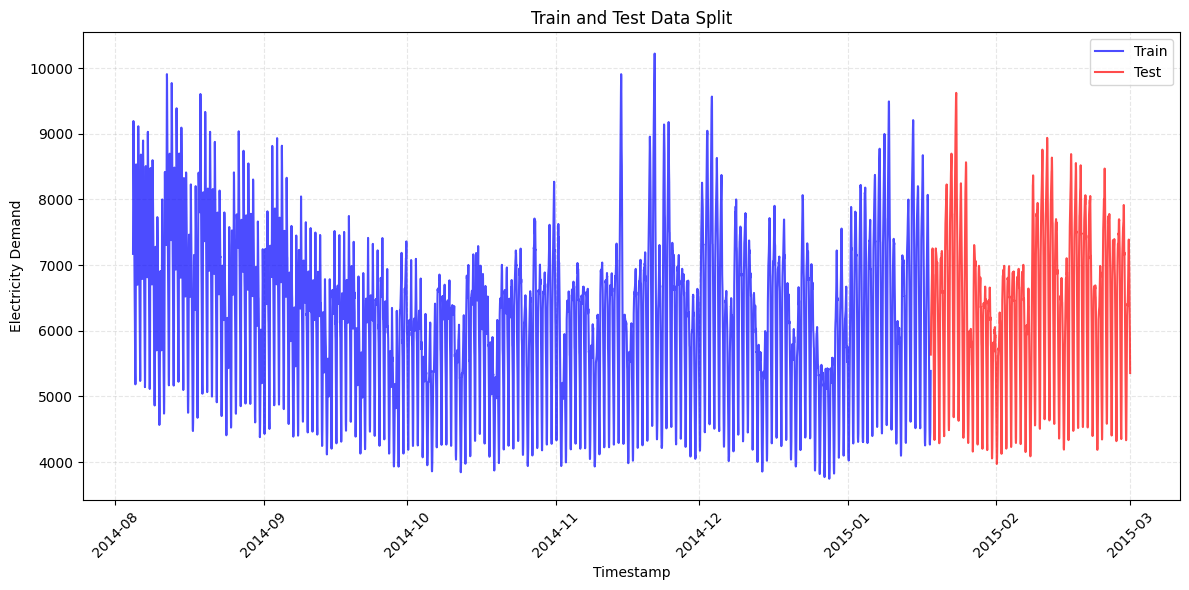

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df_train['ts'], df_train['y'], label='Train', color='blue', alpha=0.7)
plt.plot(df_test['ts'], df_test['y'], label='Test', color='red', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Electricity Demand')
plt.title('Train and Test Data Split')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
df_recent['ts'].diff().dropna().value_counts()

ts
0 days 00:30:00    9999
Name: count, dtype: int64

In [8]:
model = Model(df=df_recent)

# Baseline Model

In [ ]:
baseline = model.base_line()

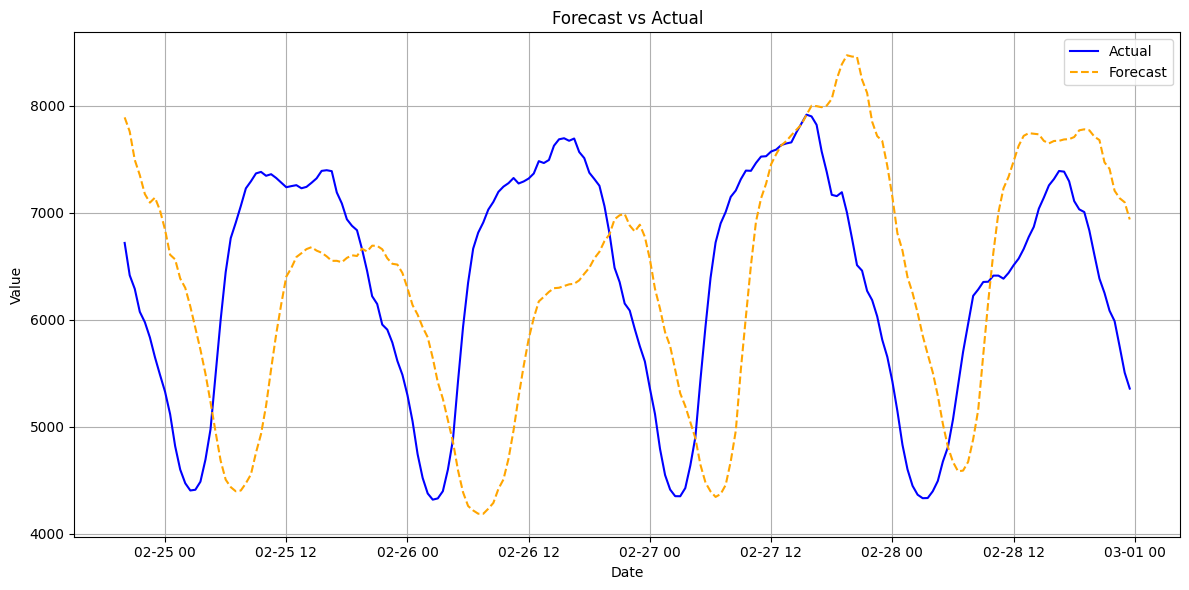

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_test['ts'], df_test['y'], label='Actual', color='blue')
plt.plot(baseline['ts'], baseline['yhat'], label='Forecast', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ARIMA

In [9]:
arima_result = model.auto_arima(m=48)

Starting ARIMA Training...



KeyboardInterrupt: 

In [11]:
arima_result.tail()

,ts,yhat
195,2015-02-28 21:30:00,5532.577228
196,2015-02-28 22:00:00,5398.115737
197,2015-02-28 22:30:00,5212.204415
198,2015-02-28 23:00:00,5004.060864
199,2015-02-28 23:30:00,4843.667642


# LSTM

In [8]:
lstm_model = model.LSTM()

Epoch 1/50


/Users/kseniablokhina/Downloads/TSF-SS25-TimeGPT/skripts/forecasting/models.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[train_df.columns] = scaler.transform(train_df)
/Users/kseniablokhina/Downloads/TSF-SS25-TimeGPT/skripts/forecasting/models.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[val_df.columns] = scaler.transform(val_df)
/Users/kseniablokhina/Library/Caches/pypoetry/virtualenvs/tsf-ss25-timegpt-vRbsAJxS-py3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.p

20/20 - 1s - 51ms/step - loss: 0.2828 - mae: 0.4605 - val_loss: 0.1276 - val_mae: 0.3075
Epoch 2/50
20/20 - 0s - 7ms/step - loss: 0.0920 - mae: 0.2524 - val_loss: 0.0758 - val_mae: 0.2225
Epoch 3/50
20/20 - 0s - 7ms/step - loss: 0.0633 - mae: 0.2151 - val_loss: 0.0544 - val_mae: 0.2024
Epoch 4/50
20/20 - 0s - 7ms/step - loss: 0.0504 - mae: 0.1932 - val_loss: 0.0347 - val_mae: 0.1596
Epoch 5/50
20/20 - 0s - 7ms/step - loss: 0.0250 - mae: 0.1367 - val_loss: 0.0169 - val_mae: 0.1085
Epoch 6/50
20/20 - 0s - 7ms/step - loss: 0.0136 - mae: 0.1000 - val_loss: 0.0153 - val_mae: 0.0999
Epoch 7/50
20/20 - 0s - 7ms/step - loss: 0.0119 - mae: 0.0915 - val_loss: 0.0126 - val_mae: 0.0889
Epoch 8/50
20/20 - 0s - 7ms/step - loss: 0.0115 - mae: 0.0896 - val_loss: 0.0114 - val_mae: 0.0860
Epoch 9/50
20/20 - 0s - 7ms/step - loss: 0.0112 - mae: 0.0858 - val_loss: 0.0110 - val_mae: 0.0851
Epoch 10/50
20/20 - 0s - 7ms/step - loss: 0.0107 - mae: 0.0827 - val_loss: 0.0105 - val_mae: 0.0832
Epoch 11/50
20/20 -

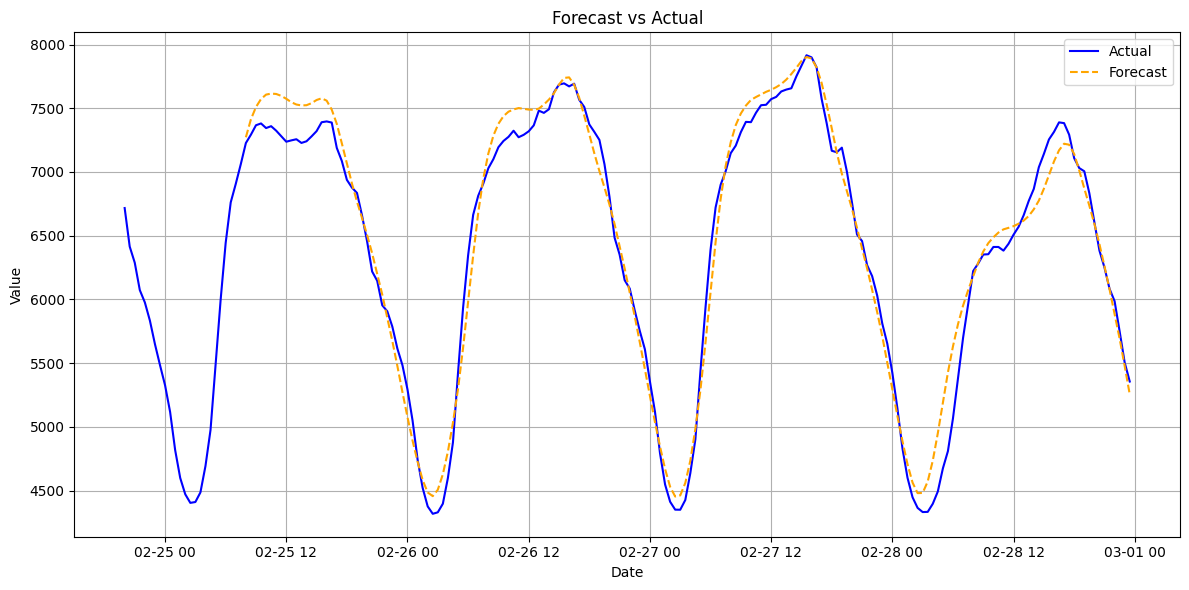

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_test['ts'], df_test['y'], label='Actual', color='blue')
plt.plot(lstm_model['ts'], lstm_model["yhat"], label='Forecast', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Prophet

In [9]:
# Forecast
model = Model(df_recent)
prophet_result = model.prophet(freq='30min')
prophet_result.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmpahlt6cpi/fhy4rx9g.json
DEBUG:cmdstanpy:input tempfile: /var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmpahlt6cpi/64j6sfh5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/I551393/Library/Caches/pypoetry/virtualenvs/tsf-ss25-timegpt-9SjHUXw4-py3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28471', 'data', 'file=/var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmpahlt6cpi/fhy4rx9g.json', 'init=/var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmpahlt6cpi/64j6sfh5.json', 'output', 'file=/var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmpahlt6cpi/prophet_modelnscj8yiy/prophet_model-20250704164443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:44:43 - cmdstanpy - INFO - Chain [1] sta

Prophet Training duration:  1.012726068496704


,ts,yhat
0,2015-01-18 08:00:00,6346.249674
1,2015-01-18 08:30:00,6436.672949
2,2015-01-18 09:00:00,6475.824238
3,2015-01-18 09:30:00,6482.569052
4,2015-01-18 10:00:00,6475.018179


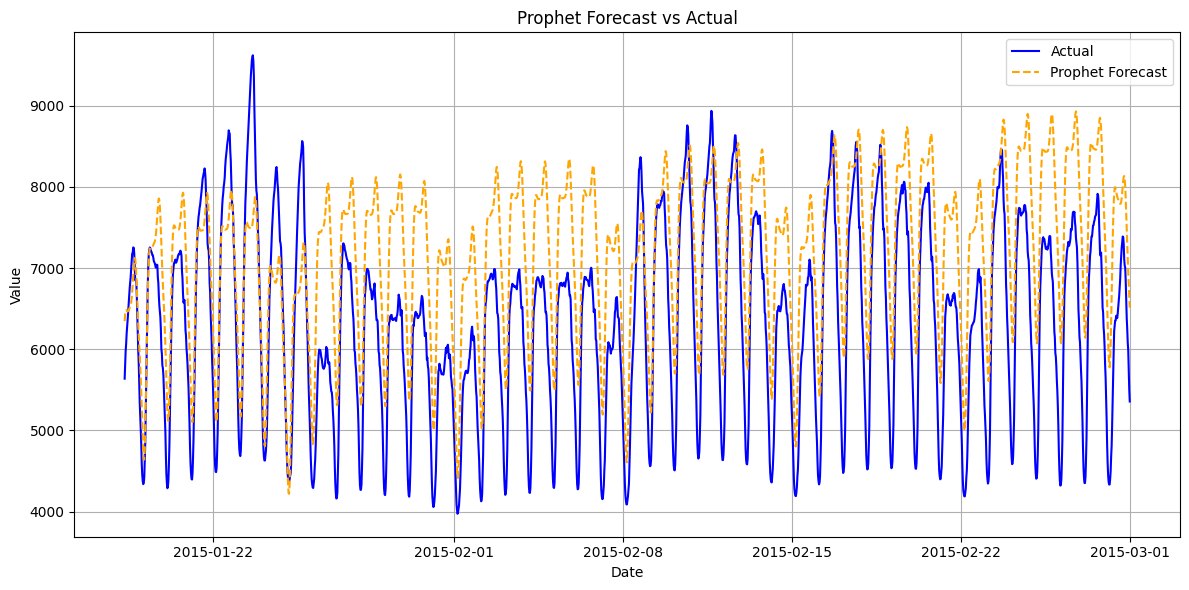

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df_test['ts'], df_test['y'], label='Actual', color='blue')
plt.plot(prophet_result['ts'], prophet_result['yhat'], label='Prophet Forecast', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prophet Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# TimesFM

In [8]:
timefm = model.times_fm("H")

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 9541.18it/s]
INFO:root:Loading checkpoint from /Users/kseniablokhina/.cache/huggingface/hub/models--google--timesfm-2.0-500m-pytorch/snapshots/dc2443792ce5516872b89b37cf1bc058c3bf0c10/torch_model.ckpt
INFO:root:Sending checkpoint to device cpu
INFO:root:Preprocessing dataframe.


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.10.18 (main, Jul  1 2025, 11:02:31) [Clang 17.0.0 (clang-1700.0.13.5)].
Finished preprocessing dataframe.


INFO:root:Finished creating output dataframe.


Finished forecasting.


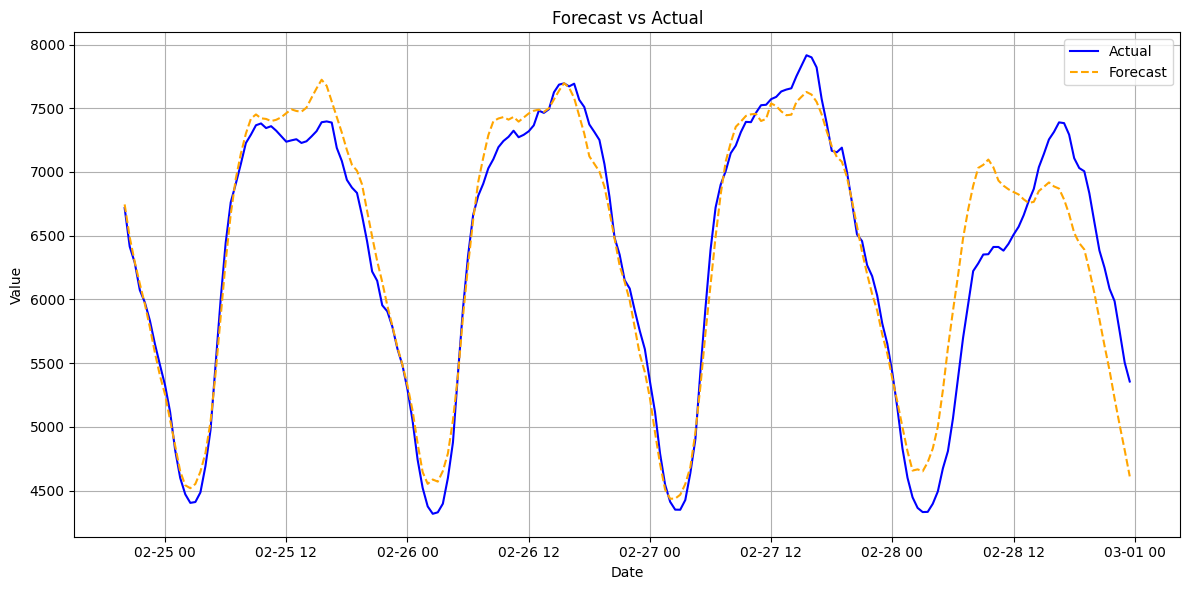

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_test['ts'], df_test['y'], label='Actual', color='blue')
plt.plot(timefm['ts'], timefm['yhat'], label='Forecast', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# TimeGPT

In [ ]:
model = Model(df_recent)
nixtla_result = model.time_gpt(horizon=36)

Nixtla DataFrame:                     ts            y unique_id
0 2014-08-04 16:00:00  7171.267818       id1
1 2014-08-04 16:30:00  7540.809382       id1
2 2014-08-04 17:00:00  8135.479068       id1
3 2014-08-04 17:30:00  8919.192144       id1
4 2014-08-04 18:00:00  9194.300292       id1


INFO:nixtla.nixtla_client:Happy Forecasting! :)
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: 30min
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...


True
Starting TimeGPT Training...



INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Nixtla Prediction Time:  3.5857598781585693


In [7]:
nixtla_result.head()

,ts,yhat
0,2015-01-18 08:00:00,5694.8564
1,2015-01-18 08:30:00,5770.0938
2,2015-01-18 09:00:00,5926.4697
3,2015-01-18 09:30:00,6077.8057
4,2015-01-18 10:00:00,6194.5312


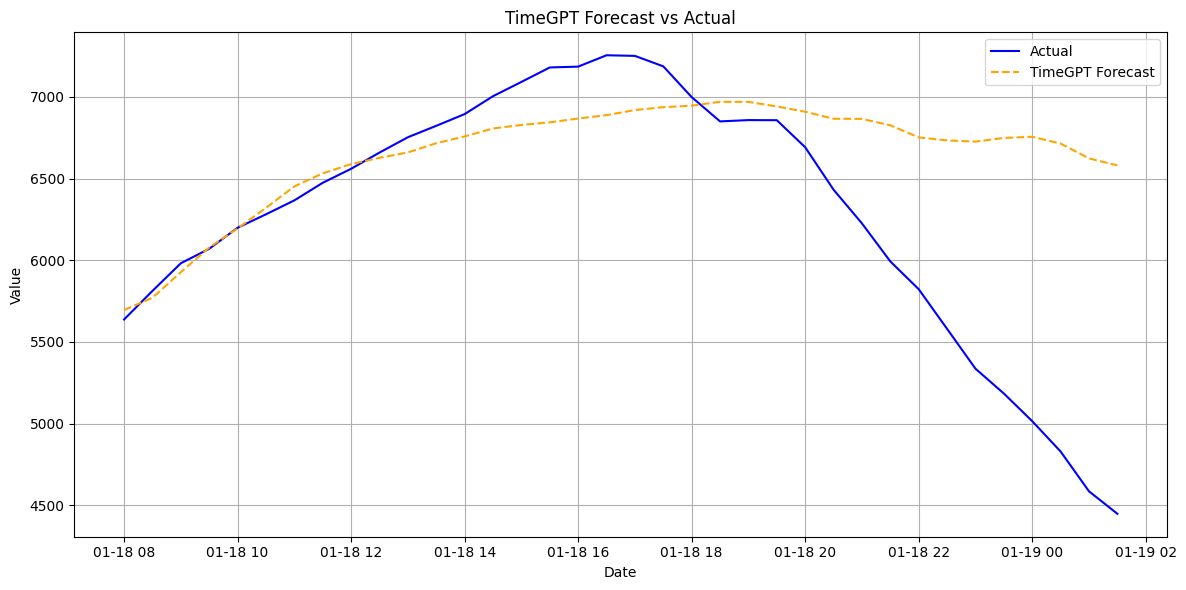

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df_test['ts'][:36], df_test['y'][:36], label='Actual', color='blue')
plt.plot(nixtla_result['ts'], nixtla_result['yhat'], label='TimeGPT Forecast', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('TimeGPT Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary

In [13]:
# Calculate metrics for all models
models_metrics = {}

# ARIMA metrics
arima_mae = mean_absolute_error(df_test['y'], arima_result['yhat'])
arima_mape = mean_absolute_percentage_error(df_test['y'], arima_result['yhat'])
arima_mse = mean_squared_error(df_test['y'], arima_result['yhat'])
models_metrics['ARIMA'] = {'MAE': arima_mae, 'MAPE': arima_mape, 'MSE': arima_mse}

# Prophet metrics
prophet_mae = mean_absolute_error(df_test['y'], prophet_result['yhat'])
prophet_mape = mean_absolute_percentage_error(df_test['y'], prophet_result['yhat'])
prophet_mse = mean_squared_error(df_test['y'], prophet_result['yhat'])
models_metrics['Prophet'] = {'MAE': prophet_mae, 'MAPE': prophet_mape, 'MSE': prophet_mse}

# TimeGPT metrics
nixtla_mae = mean_absolute_error(df_test['y'], nixtla_result['yhat'])
nixtla_mape = mean_absolute_percentage_error(df_test['y'], nixtla_result['yhat'])
nixtla_mse = mean_squared_error(df_test['y'], nixtla_result['yhat'])
models_metrics['TimeGPT'] = {'MAE': nixtla_mae, 'MAPE': nixtla_mape, 'MSE': nixtla_mse}

# Display results
metrics_df = pd.DataFrame(models_metrics).T
print("Model Performance Metrics:")
print(metrics_df.round(4))

Model Performance Metrics:
              MAE    MAPE           MSE
ARIMA    283.6021  0.0460  1.254444e+05
Prophet  326.1597  0.0526  1.701888e+05
TimeGPT  894.6087  0.1593  1.152736e+06


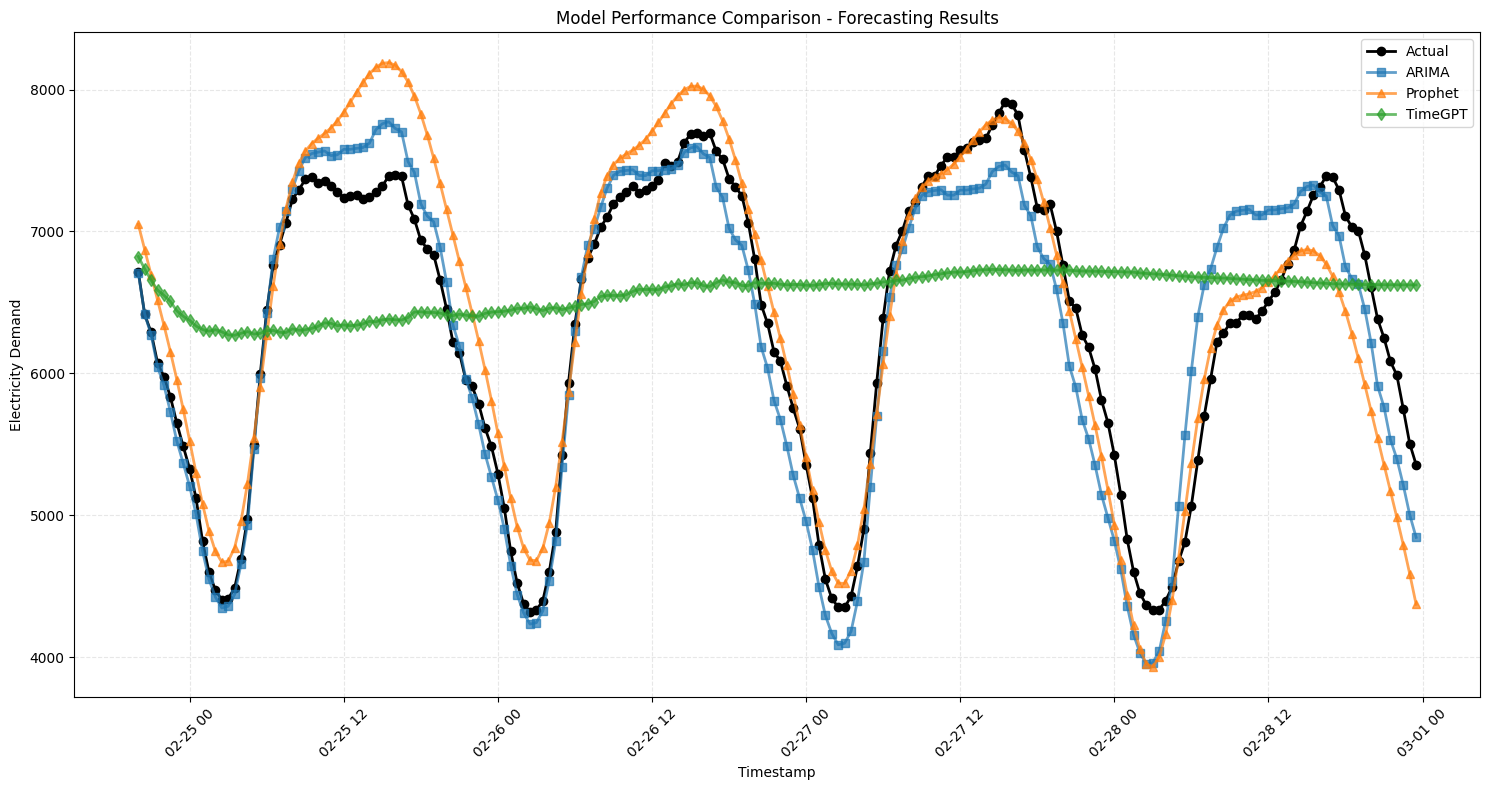

In [14]:
plt.figure(figsize=(15, 8))

# Plot actual values
plt.plot(df_test['ts'], df_test['y'], label='Actual', marker='o', linewidth=2, color='black')

# Plot ARIMA predictions (filter out NaN values)
arima_valid = arima_result.dropna()
plt.plot(arima_valid['ts'], arima_valid['yhat'], label='ARIMA', marker='s', linewidth=2, alpha=0.7)

# Plot Prophet predictions
plt.plot(prophet_result['ts'], prophet_result['yhat'], label='Prophet', marker='^', linewidth=2, alpha=0.7)

# Plot TimeGPT predictions
plt.plot(nixtla_result['ts'], nixtla_result['yhat'], label='TimeGPT', marker='d', linewidth=2, alpha=0.7)

plt.xlabel('Timestamp')
plt.ylabel('Electricity Demand')
plt.title('Model Performance Comparison - Forecasting Results')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()